In [1]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

using gpu 2


In [2]:
#Checking wich GPU is beeing used

!nvidia-smi

Mon Dec 20 14:49:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   27C    P8    17W / 250W |   3065MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [3]:
#Load data
data_speaker1_dir = 'dialogue/Dataset/SameVoiceDetection/sr44khz/44khz100_10_speaker1.npy'
#data_speaker1_dir = 'dialogue/Leander/outputs/speaker1.npy'
data_speaker2_dir = 'dialogue/Dataset/SameVoiceDetection/sr44khz/44khz100_10_speaker2.npy'
#data_speaker2_dir = 'dialogue/Leander/outputs/speaker2.npy'
labels_dir = 'dialogue/Dataset/SameVoiceDetection/sr44khz/44khz100_10_labels.npy'
#labels_dir = 'dialogue/Leander/outputs/labels.npy'

data_speaker1 = np.load(data_speaker1_dir, allow_pickle = True)
data_speaker2 = np.load(data_speaker2_dir, allow_pickle = True)
#data_speaker1 = data_speaker1.reshape((len(data_speaker1),40,len(data_speaker1[0])//40))
#data_speaker2 = data_speaker2.reshape((len(data_speaker2),40,len(data_speaker2[0])//40))
labels = np.load(labels_dir, allow_pickle = True)

print(data_speaker1.shape, data_speaker2.shape)
print(labels)

(180000, 40, 44) (180000, 40, 44)
[ True False  True ... False  True False]


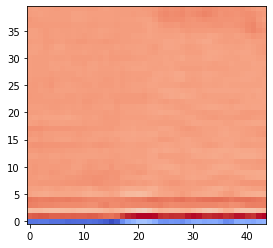

In [4]:
from matplotlib import cm
fig, ax = plt.subplots()
mfcc_data = data_speaker1[1]
cox = ax.imshow(mfcc_data, interpolation = 'nearest', cmap = cm.coolwarm, origin = 'lower')
plt.show()

In [5]:
#df_data.drop(['isSpeaking'],axis = 1)
X1_train, X1_val, y_train, y_val = train_test_split(data_speaker1, labels, test_size = 0.2, random_state = 23)
X1_train, X1_test, y_train, y_test = train_test_split(X1_train, y_train, test_size = 0.2, random_state = 23)

X2_train, X2_val, y_train, y_val = train_test_split(data_speaker2, labels, test_size = 0.2, random_state = 23)
X2_train, X2_test, y_train, y_test = train_test_split(X2_train, y_train, test_size = 0.2, random_state = 23)

print(type(X1_train))
#print(X_train)

<class 'numpy.ndarray'>


In [6]:
X1_train = torch.from_numpy(X1_train).float()

X2_train = torch.from_numpy(X2_train).float()

y_train = torch.from_numpy(y_train).float()

X1_val = torch.from_numpy(X1_val).float()

X2_val = torch.from_numpy(X2_val).float()

y_val = torch.from_numpy(y_val).float()

X1_test = torch.from_numpy(X1_test).float()

X2_test = torch.from_numpy(X2_test).float()

y_test = torch.from_numpy(y_test).float()

print(X2_train.shape, y_train.shape)

print(X2_train[0])


torch.Size([115200, 40, 44]) torch.Size([115200])
tensor([[-4.5319e+02, -4.6784e+02, -4.8883e+02,  ..., -3.2153e+02,
         -3.2517e+02, -3.3646e+02],
        [ 2.0541e+02,  1.9636e+02,  1.7664e+02,  ...,  2.4254e+02,
          2.4610e+02,  2.4839e+02],
        [ 1.8906e+01,  2.2520e+01,  2.2753e+01,  ..., -7.9404e+01,
         -6.8997e+01, -5.4620e+01],
        ...,
        [-6.8194e+00, -9.7588e+00, -1.3276e+01,  ..., -1.1883e+01,
         -7.5521e+00, -7.1712e+00],
        [-2.3469e+00, -6.7821e+00, -1.0921e+01,  ..., -2.7668e+00,
          1.1747e+00,  1.7973e+00],
        [-1.9728e+00, -5.7779e+00, -9.1388e+00,  ...,  1.9530e-01,
          7.5064e-01,  2.0396e+00]])


In [7]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 40, kernel_size=7, stride = 1, padding = 3, padding_mode= 'zeros') #40 input channels, 40 output channels
        self.conv2 = nn.Conv1d(40, 60, kernel_size=5, stride = 1, padding = 2, padding_mode= 'zeros') #40 input channels from previous Conv. layer, 80 out
        self.conv3 = nn.Conv1d(60, 70, kernel_size=3, stride = 1, padding = 1, padding_mode= 'zeros')
        self.conv4 = nn.Conv1d(70, 80, kernel_size=3, stride = 1, padding = 1, padding_mode= 'zeros')

        self.fc1 = nn.Linear(320, 200) #Fully-connected classifier layer 
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1) #Fully-connected classifier layer
    
    def forward_one_voice(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        x = F.relu(F.max_pool1d(self.conv3(x), 2))
        x = F.relu(F.max_pool1d(self.conv4(x), 2))
        
        x = x.reshape(len(x), -1)
        batch_size = len(x)
        
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_one_voice(x1)
        x2 = self.forward_one_voice(x2)
        x = torch.concat([x1, x2], axis = 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X1_train.shape[1],kernel_size = 3)

In [8]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.00003)

In [9]:
train_ds = TensorDataset(X1_train, X2_train, y_train)
val_ds = TensorDataset(X1_val, X2_val, y_val)

In [10]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size= batch_size, num_workers = 4, pin_memory = True)
#val_dl = DataLoader(val_ds, batch_size= 32)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X1_train = X1_train.to(device)
# X2_train = X2_train.to(device)
# y_train = y_train.to(device)
X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
y_val = y_val.to(device)

X1_test = X1_test.to(device)
X2_test = X2_test.to(device)
y_test = y_test.to(device)

CNN = CNN.to(device)
criterion = criterion.to(device)
print(device)

cuda


In [12]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [13]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)
    
Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_val', 'val_loss', 'train_loss'])
    
for epoch in range(100):
    y_acc = torch.empty((batch_size),dtype= torch.int32, device = 'cuda')
    y_pred_acc = torch.empty((batch_size), device = 'cuda')
    for x1, x2, y in train_dl:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = CNN(x1, x2)
        y_pred = y_pred.squeeze()
        train_loss = criterion(y_pred, y)
        train_loss.backward()
        optimizer.step()
        y_acc = torch.concat([y, y_acc], axis = 0)
        y_pred_acc = torch.concat([y_pred, y_pred_acc], axis = 0)
        print('{}MB allocated'.format(torch.cuda.memory_allocated()/1024**2))
    if epoch % 1 == 0:


        train_acc = calculate_accuracy(y_acc, CNN.post_forward(y_pred_acc))
    
        y_val_pred = CNN(X1_val, X2_val)
        y_val_pred = y_val_pred.squeeze()
        val_loss = criterion(y_val_pred, y_val)
    
        val_acc = calculate_accuracy(y_val, CNN.post_forward(y_val_pred))
    
        result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_val': round_tensor(val_acc), 'val_loss': round_tensor(val_loss), 'train_loss': round_tensor(train_loss)}

        Results = Results.append(result, ignore_index=True)

        print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
val  set - loss: {round_tensor(val_loss)}, accuracy: {round_tensor(val_acc)}
''')

epoch 0
Train set - loss: 0.501, accuracy: 0.64
val  set - loss: 0.501, accuracy: 0.757

epoch 1
Train set - loss: 0.511, accuracy: 0.774
val  set - loss: 0.451, accuracy: 0.79

epoch 2
Train set - loss: 0.453, accuracy: 0.798
val  set - loss: 0.426, accuracy: 0.804

epoch 3
Train set - loss: 0.413, accuracy: 0.813
val  set - loss: 0.405, accuracy: 0.816

epoch 4
Train set - loss: 0.382, accuracy: 0.827
val  set - loss: 0.385, accuracy: 0.828

epoch 5
Train set - loss: 0.311, accuracy: 0.84
val  set - loss: 0.363, accuracy: 0.841

epoch 6
Train set - loss: 0.282, accuracy: 0.852
val  set - loss: 0.341, accuracy: 0.854

epoch 7
Train set - loss: 0.291, accuracy: 0.861
val  set - loss: 0.328, accuracy: 0.859

epoch 8
Train set - loss: 0.298, accuracy: 0.867
val  set - loss: 0.317, accuracy: 0.865

epoch 9
Train set - loss: 0.322, accuracy: 0.874
val  set - loss: 0.307, accuracy: 0.871

epoch 10
Train set - loss: 0.352, accuracy: 0.88
val  set - loss: 0.297, accuracy: 0.875

epoch 11
Trai

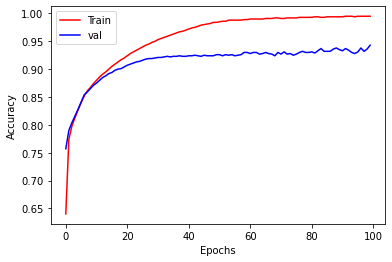

    Epoch  Acc_train  Acc_val  val_loss  train_loss
0     0.0      0.640    0.757     0.501       0.501
1     1.0      0.774    0.790     0.451       0.511
2     2.0      0.798    0.804     0.426       0.453
3     3.0      0.813    0.816     0.405       0.413
4     4.0      0.827    0.828     0.385       0.382
..    ...        ...      ...       ...         ...
95   95.0      0.995    0.931     0.434       0.007
96   96.0      0.995    0.938     0.467       0.007
97   97.0      0.995    0.932     0.475       0.000
98   98.0      0.995    0.936     0.537       0.020
99   99.0      0.995    0.943     0.557       0.007

[100 rows x 5 columns]


In [14]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_val,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

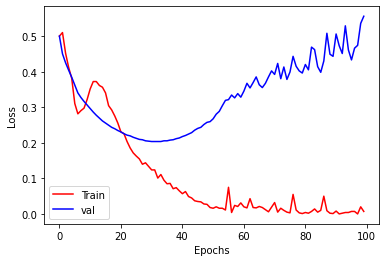

In [15]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.val_loss,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [16]:
classes = ['Different Voice', 'Same Voice']
y_pred = CNN(X1_val, X2_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.96      0.92      0.94     18016
     Same Voice       0.93      0.96      0.94     17984

       accuracy                           0.94     36000
      macro avg       0.94      0.94      0.94     36000
   weighted avg       0.94      0.94      0.94     36000



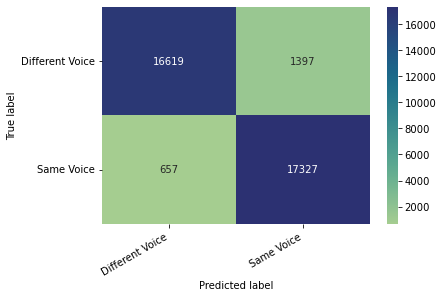

In [17]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [18]:
y_pred = CNN(X1_test, X2_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.96      0.92      0.94     14349
     Same Voice       0.93      0.96      0.94     14451

       accuracy                           0.94     28800
      macro avg       0.94      0.94      0.94     28800
   weighted avg       0.94      0.94      0.94     28800



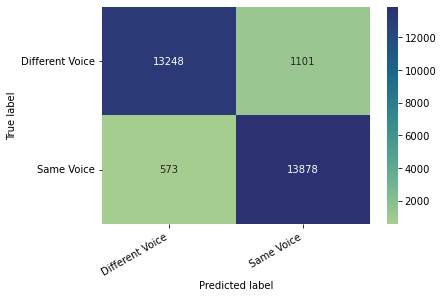

In [19]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [20]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.


In [23]:
print("Model's state_dict:")
for param_tensor in CNN.state_dict():
    print(param_tensor, "\t", CNN.state_dict()[param_tensor].size())
    
torch.save(CNN.state_dict(), "./dialogue/Model/voice_comparison_model")

Model's state_dict:
conv1.weight 	 torch.Size([40, 40, 7])
conv1.bias 	 torch.Size([40])
conv2.weight 	 torch.Size([60, 40, 5])
conv2.bias 	 torch.Size([60])
conv3.weight 	 torch.Size([70, 60, 3])
conv3.bias 	 torch.Size([70])
conv4.weight 	 torch.Size([80, 70, 3])
conv4.bias 	 torch.Size([80])
fc1.weight 	 torch.Size([200, 320])
fc1.bias 	 torch.Size([200])
fc2.weight 	 torch.Size([100, 200])
fc2.bias 	 torch.Size([100])
fc3.weight 	 torch.Size([1, 100])
fc3.bias 	 torch.Size([1])


In [22]:
!ls

dialogue  dllectures21	voice_comparison_model
